In [20]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import sklearn
import brainiak
import nilearn as nl
from nilearn import image, plotting, input_data

from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

In [21]:
from sklearn.linear_model import LogisticRegression
pd.options.display.max_rows = 200

# load dataframes with timing and order information

In [34]:
""" onset and offset TR for each state of each wedding """
timing_df_view = pd.read_csv('deriv/timing_df_viewing.csv',index_col=0)
print('\n',timing_df_view.head())
timing_df_recal = pd.read_csv('deriv/timing_df_recall.csv',index_col=0)
print('\n',timing_df_recal.head())
wedclass_df = pd.read_csv('deriv/NvSclass_df.csv',index_col=0)
print('\n',wedclass_df.head())

def extract_TRs_view(wed_num):
  """
  returns a L containing the valid TRs in wed_num
    NB consistent across subjects
  valid TRs are those within a vid
  """
  timing_df = timing_df_view
  wed_timing_df = timing_df[timing_df.wed_num == wed_num]
  L = []
  for i,row in wed_timing_df.iterrows():
    vid_TRs = np.arange(row.onset_TR,row.offset_TR)
    L.extend(vid_TRs)
  return L

def extract_TRs_recall(sub_num,wed_id):
  """
  returns a L containing the valid TRs in wed_num
    NB consistent across subjects
  valid TRs are those within a vid
  """
  timing_df = timing_df_recal
  # wed_timing_df = timing_df[timing_df.wed_num == wed_num]
  df_row = timing_df[(timing_df.wed_id==wed_id) & (timing_df.sub_num==sub_num)]
  TRs = np.arange(df_row.onset_TR.values,df_row.offset_TR.values)
  wed_class = df_row.wed_class.values[0]
  return TRs,wed_class


    wed_num  vid_str  onset_TR  len_TRs  offset_TR
0        0  vid1a_q        12       17         29
1        0  vid1b_q        29        6         35
2        0   vid2_q        35       11         46
3        0   vid3_q        49       15         64
4        0   vid4_q        67       16         83

    sub_num  wed_id  onset_TR  offset_TR wed_class
0        2      34         0         27       NaN
1        2      29        27         46       NaN
2        2      17        46         63       NaN
3        2      38        63         81       NaN
4        2       6        81        124       NaN

   NorS  wed_id  wed_num  sub_num
0    S      20        0        3
1    N      23        1        3
2    N       6        2        3
3    S      17        3        3
4    S      38        4        3


In [6]:
get_wed_label = lambda sub_num,wed_num:\
  order_df[(
    order_df.sub_num == sub_num) & (
    order_df.wed_num == wed_num
  )].NorS.values[0]

In [7]:
fold_full_L = [
    [0,1],[2,3],[4,5],
    [6,7],[8,9],[10,11]
  ]

In [8]:
def get_fold_info(sub_num,fold_L):
  """ 
  """
  Y_label = []
  X_TRs = []
  ## TEST TRS
  for wed_num in fold_L:
    # X TRs
    wed_TRs = extract_TRs(wed_num)
    X_TRs.extend(wed_TRs)
    # Y labels
    y_wed = np.repeat(get_wed_label(sub_num,wed_num)=='N',len(wed_TRs)).astype(int)
    Y_label.extend(y_wed)
  return X_TRs,Y_label

In [9]:
def load_sub_roi(sub_num,task,roi_name):
  fpath = "sub-%i_task-%s_roi-%s.npy" %(sub_num,task,roi_name)
  return np.load('data/fmri/masked/'+fpath)

In [10]:
get_fold_L_train = lambda fold_num: [j for i in fold_full_L if i!=fold_full_L[fold_num] for j in i]

In [11]:
get_fold_L_train(2)

[0, 1, 2, 3, 6, 7, 8, 9, 10, 11]

# xval loop

In [12]:
SUB_NS = np.arange(1,45)

In [13]:
""" 
xval loop 
"""

def xval(roi_name,clf_c):
  yhat_L = []
  for sub_num in SUB_NS:
    print(sub_num)
    try:
      sub_roi = load_sub_roi(sub_num,'videos',roi_name)
    except:
      print('failed to load sub_roi, S=',sub_num,'roi=',roi_name)
      continue
    # fold information
    for fold_num in range(6):
      fold_L_test = fold_full_L[fold_num]
      fold_L_train = get_fold_L_train(fold_num)
      print('test',fold_L_test,'train',fold_L_train)
      # TRAIN DATA
      X_TRs_train,Y_train = get_fold_info(sub_num,fold_L_train)
      X_train = sub_roi[X_TRs_train,:]
      # TEST DATA
      X_TRs_test,Y_test = get_fold_info(sub_num,fold_L_test)
      X_test = sub_roi[X_TRs_test,:]
      # NORMALIZE
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)
      # CLASSIFIER
      clf = sklearn.linear_model.LogisticRegression(solver='liblinear',C=clf_c)
      clf.fit(X_train,Y_train)
      yhat_full = clf.predict_proba(X_test)
      # split eval of test TRs into two weddings
      # and plot proba of correct schema
      yhat_first = yhat_full[:int(len(yhat_full)/2),Y_test[0]]
      yhat_second = yhat_full[int(len(yhat_full)/2):,Y_test[-1]]
      yhat_L.append(yhat_first)
      yhat_L.append(yhat_second)
  return np.array(yhat_L)


In [14]:
## compute mean
roi_name = 'rglasser_PM_net'
clf_c = 1.0
yhat = xval(roi_name=roi_name,clf_c=clf_c)
yhat.shape

1
failed to load sub_roi, S= 1 roi= rglasser_PM_net
2
failed to load sub_roi, S= 2 roi= rglasser_PM_net
3
failed to load sub_roi, S= 3 roi= rglasser_PM_net
4
failed to load sub_roi, S= 4 roi= rglasser_PM_net
5
failed to load sub_roi, S= 5 roi= rglasser_PM_net
6
failed to load sub_roi, S= 6 roi= rglasser_PM_net
7
failed to load sub_roi, S= 7 roi= rglasser_PM_net
8
failed to load sub_roi, S= 8 roi= rglasser_PM_net
9
failed to load sub_roi, S= 9 roi= rglasser_PM_net
10
failed to load sub_roi, S= 10 roi= rglasser_PM_net
11
failed to load sub_roi, S= 11 roi= rglasser_PM_net
12
failed to load sub_roi, S= 12 roi= rglasser_PM_net
13
failed to load sub_roi, S= 13 roi= rglasser_PM_net
14
failed to load sub_roi, S= 14 roi= rglasser_PM_net
15
failed to load sub_roi, S= 15 roi= rglasser_PM_net
16
failed to load sub_roi, S= 16 roi= rglasser_PM_net
17
failed to load sub_roi, S= 17 roi= rglasser_PM_net
18
failed to load sub_roi, S= 18 roi= rglasser_PM_net
19
failed to load sub_roi, S= 19 roi= rglasser

(96, 72)

In [15]:
M = yhat.mean(0)
S = yhat.std(0) / np.sqrt(len(yhat))

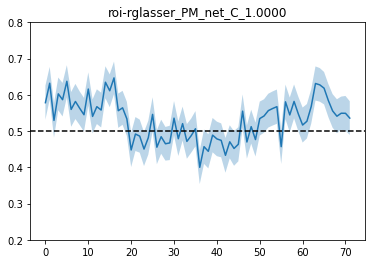

In [16]:
## plt
ax = plt.gca()
ax.plot(M)
ax.fill_between(np.arange(len(M)),M-S,M+S,alpha=.3)
ax.axhline(0.5,c='k',ls='--')
ax.set_ylim(0.2,0.8)
ax.set_title('roi-%s_C_%.4f'%(roi_name,clf_c))
plt.savefig('figures/NvS_logreg_roi-%s_C%.4f-nsubs_%i.png'%(roi_name,clf_c,int(len(M)/12)))